In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, auc, plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import eli5
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df1_test = pd.read_csv('../data/ht_match_na.csv')
df2_test = pd.read_csv('../data/ht_match_ind_na.csv')

df = df_join(df1,df2)
df_test = df_join(df1_test, df2_test)

In [8]:
y = df['win']
X = df.drop(columns=['match_id','win'])

X_cols = X.columns

#### Converting team names ('red', 'blue') to 1 and 0

In [11]:
mask = {'blue':0,'red':1}
X['teams'] = X['teams'].replace(mask)
df_test['teams'] = df_test['teams'].replace(mask)

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [13]:
num_features, cat_features = feature_separator(X)

In [14]:
scaled_pl = pipeline(True,num_features,False, True)
unscaled_pl = pipeline(True,num_features,False, False)

In [15]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [16]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.91
Recall score for scaled log reg: 0.86


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.90
Recall score for unscaled random forest: 0.89


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.90
Recall score for scaled gradient boost: 0.87


Mean cross validatin score for scaled Bayesian: 0.85
Precision score for scaled Bayesian: 0.85
Recall score for scaled Bayesian: 0.82




## Comparing ROC AUC Curves for base models

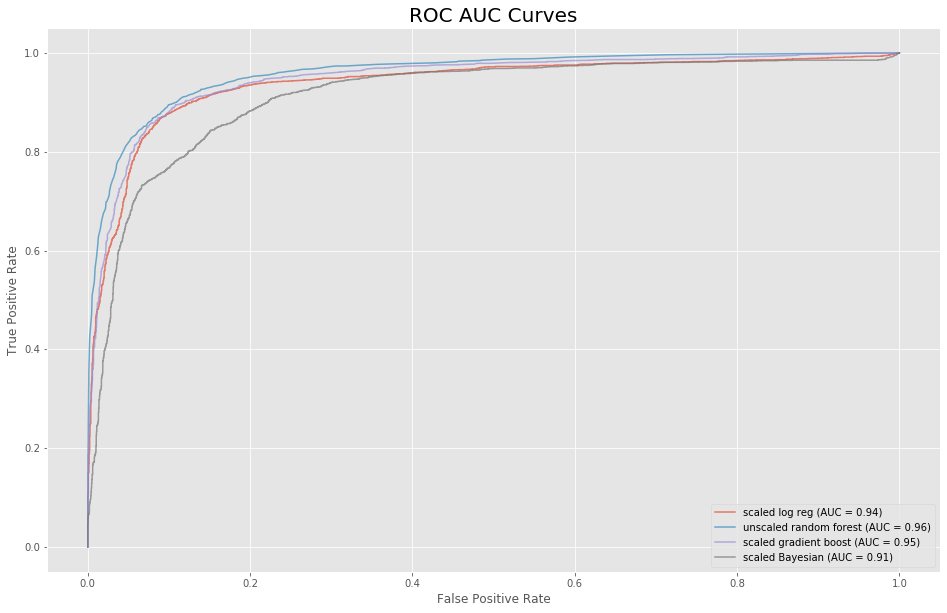

In [17]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X_train, y_train, X_validation, y_validation)

## Feature engineering with a chosen model

##### Logistic regression coefficients

In [18]:
weight_explainer(lrc_s,num_features)

Weight?,Feature
+3.278,xp
+1.839,firstInhibitor
+0.843,firstBaron
+0.692,firstTower
+0.489,totalKills
+0.424,firstDragon
+0.347,<BIAS>
+0.170,firstBlood
+0.051,firstRiftHerald
+0.012,teams


In [19]:
lrc_s.named_steps['estimator'].coef_

array([[ 0.01205005,  0.17014733,  0.69166027,  1.83916573,  0.84266001,
         0.42406207,  0.05145782, -2.32476092, -1.78031548,  3.27778986,
         0.48912554, -0.40777115, -0.08630288]])

##### Random forest feature importance

In [20]:
weight_explainer(rfc_u,num_features)

Weight,Feature
0.3382 ± 0.2042,firstInhibitor
0.1137 ± 0.1394,firstTower
0.0810 ± 0.0569,totalDeaths
0.0789 ± 0.0402,totalGold
0.0763 ± 0.0422,xp
0.0706 ± 0.0404,level
0.0697 ± 0.0932,firstBaron
0.0546 ± 0.0409,totalKills
0.0453 ± 0.0332,level_ups
0.0309 ± 0.0578,firstDragon


Which features to use before hyperparameter tuning?

## Tuning hyperparameters

In [ ]:
params = {'estimator__n_estimators': (10, 100,1000,10000),
         'estimator__max_depth': (2,4,6,None),
         'estimator__max_features': (3,6,'auto'),
         }

search = GridSearchCV(rfc_u,params,n_jobs=-1,verbose=1)
search.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min


In [ ]:
search.best_params_

## CV score against the entire training dataset

## Confusion Matrix

## Using the best model against the test dataset

## Result